
Dropped columns due to missing values (35):
 - (E)-2-Pentenal Area
 - (E)-Linalool oxide Area
 - 1-Octen-3-ol Area
 - 2-Acetylpyrrole Area
 - 2-Ethylfuran Area
 - 2-Hexanone Area
 - 2-Methylpentan-2-ol Area
 - 2-Pentanol Area
 - 3-Hexanone Area
 - 3-Methyl-2-butanone Area
 - 3-Methyl-3-butenyl acetate Area
 - 6-Methoxyeugenol Area
 - Acetal Area
 - Allyl isothiocyanate Area
 - Butyl acetate Area
 - Butyric acid Area
 - Dihydrocarveol Area
 - Ethyl 2-methylbutyrate Area
 - Ethyl isobutyrate Area
 - Ethyl lactate Area
 - Ethyl vinyl ketone Area
 - Geranyl isovalerate Area
 - Isobutyric acid Area
 - Isopropyl hexanoate Area
 - Methyl 2-methylbutyrate Area
 - Methyl hexanoate Area
 - Methyl isobutyl ketone Area
 - Methyl isovalerate Area
 - Neodihydrocarveol Area
 - Propanoic acid Area
 - Propyl acetate Area
 - Tetrahydrothiophene Area
 - alpha-Pinene Area
 - beta-Pinene Area
 - cis-3-Hexen-1-ol Area
Cross-validated accuracy: 1.00


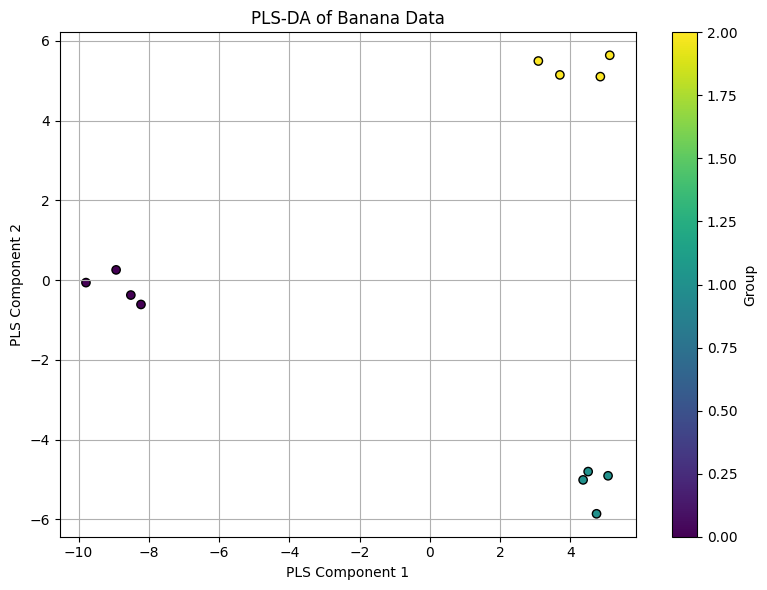

ValueError: operands could not be broadcast together with shapes (12,) (3,) 

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
 

# ----------------------
# Step 1: Load and clean
# ----------------------

'''
Choice here between filled data or non-filled 
'''
# Load the dataset (group impute, nans filled with pseudocount)
#df = pd.read_csv("badata_imputed_filled.csv")

df = pd.read_csv('badata_imputed.csv') #this one imputes median of category per column if available but has many NaNs
'''
pick the preproces file carefully
'''

df = df.drop(columns=[df.columns[0]])  # Drop index

# Separate labels(y) and features(X)
y_raw = df['Groups']
X_raw = df.drop(columns=['Groups'])

# Identify and drop columns with any missing values
missing_cols = X_raw.columns[X_raw.isna().any()].tolist()
print(f"\nDropped columns due to missing values ({len(missing_cols)}):")
for col in missing_cols:
    print(f" - {col}")

X = X_raw.drop(columns=missing_cols)


# use one hot encode to change ripeness to numerical values
onehot = OneHotEncoder(sparse_output=False)
y= onehot.fit_transform(y_raw.values.reshape(-1, 1))


X_log = np.log10(X)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)
 
# Apply PLS-DA
pls = PLSRegression(n_components=2)
X_scores, _ = pls.fit_transform(X_scaled, y)
 
# Cross-validation
y_pred = cross_val_predict(pls, X_scaled, y, cv=5)
y_true_labels = np.argmax(y, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f'Cross-validated accuracy: {accuracy:.2f}')

# Plot
color_map = {'Green': 0, 'Ripe': 1, 'Overripe': 2}
colors = y_raw.map(color_map)

plt.figure(figsize=(8, 6))
plt.scatter(X_scores[:, 0], X_scores[:, 1], c=colors, cmap='viridis', edgecolor='k')
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.title('PLS-DA of Banana Data')
plt.colorbar(label='Group')
plt.grid(True)
plt.tight_layout()
plt.show()


# VIP score calculation
def calculate_vip(pls_model, X_scaled, y_onehot):
    t = pls_model.x_scores_
    w = pls_model.x_weights_
    q = pls_model.y_loadings_

    p, h = w.shape
    s = np.zeros((h,))
    for i in range(h):
         s[i] = np.sum((t[:, i] ** 2) * (q[:, i] ** 2))

    total_s = np.sum(s)
    vip = np.zeros((p,))
    for i in range(p):
        weight = np.array([(w[i, j] ** 2) * s[j] for j in range(h)])
        vip[i] = np.sqrt(p * np.sum(weight) / total_s)
    return vip

vip_scores = calculate_vip(pls, X_scaled, y)
vip_df = pd.DataFrame({'Feature': X_clean.columns, 'VIP': vip_scores})
vip_df_sorted = vip_df.sort_values(by='VIP', ascending=False)

# Plot top 15 VIP features
top_n = 15
plt.figure(figsize=(10, 6))
plt.barh(vip_df_sorted['Feature'].head(top_n)[::-1], vip_df_sorted['VIP'].head(top_n)[::-1], color='teal')
plt.xlabel('VIP Score')
plt.title(f'Top {top_n} Features by VIP Score')
plt.tight_layout()
plt.show()

